# imports

In [ ]:
!pip install --upgrade --quiet keras-cv tensorflow
!pip install --upgrade --quiet keras
!pip install --upgrade --quiet pandas numpy pillow matplotlib

In [18]:
import os
import PIL
import keras
import keras_cv
import cv2
import random
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
#import albumentations as A

import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
from fractions import Fraction
from collections import Counter

# datasets

## definitions

In [2]:

def grid_search(params):
    keys = list(params.keys())
    for values in itertools.product(*(params[key] for key in keys)):
        yield dict(zip(keys, values))


def is_batched(dataset):
    element_spec = dataset.element_spec
    # For Tensor datasets, check shape
    if hasattr(element_spec, 'shape'):
        return element_spec.shape.rank > 0 and element_spec.shape[0] is None
    # For nested structures (e.g., dicts, tuples), check each component
    elif isinstance(element_spec, (dict, tuple)):
        return any(is_batched(dataset.map(lambda x: x[key])) for key in element_spec)
    return False


def get_real_samples(ds):
    """
    deals with batched pain
    :param ds:
    :return:
    """
    for sample in ds:
        images, boxes, classes = parse_sample_auto(sample)

        if len(images.shape) == 3:  # non-batched
            images = [images]  # or np.expanddims axis = 0
            boxes = [boxes]
            classes = [classes]

        for image, boxes, classes in zip(images, boxes, classes):
            yield image, boxes, classes


def build_output_signature(d_img, d_bb, tsz):
    """
    computes output signature based on parameters
    :param d_img: bool
    :param d_bb: bool
    :param tsz: tuple
    :return: tuple
    """
    sig_x = {"images": tf.TensorSpec(shape=(*tsz, 3), dtype=tf.float32)} if d_img else tf.TensorSpec(shape=(*tsz, 3),
                                                                                                     dtype=tf.float32)
    sig_y = {
        "bounding_boxes": {
            "boxes": tf.TensorSpec(shape=(1, 4), dtype=tf.float32),
            "classes": tf.TensorSpec(shape=(1,), dtype=tf.int32)
        }
    } if d_bb else {
        "boxes": tf.TensorSpec(shape=(1, 4), dtype=tf.float32),
        "classes": tf.TensorSpec(shape=(1,), dtype=tf.int32)
    }

    return (sig_x, sig_y)


def parse_sample_auto(sample):
    """
    Automatically parses a sample tuple (x, y) and returns image, box, and class.
    Handles combinations of:
      - x being a plain tensor or a dict with key 'images'
      - y being a flat dict or nested under 'bounding_boxes'

    :param sample: A tuple (x, y) from the dataset
    :return: tuple (image, box, cls)
    """
    x, y = sample

    # Handle image (either raw tensor or dict with 'images')
    if isinstance(x, dict) and "images" in x:
        image = x["images"]
    else:
        image = x

    # Handle y — nested under 'bounding_boxes' or not
    if isinstance(y, dict) and "bounding_boxes" in y:
        box = y["bounding_boxes"]["boxes"]
        cls = y["bounding_boxes"]["classes"]
    else:
        box = y["boxes"]
        cls = y["classes"]

    return image, box, cls


def shape_coin_output(d_img, d_bb, img, box, cls=0):
    """
    matches output signature
    :param d_img: bool
    :param d_bb: bool
    :param img: np.array
    :param box: np.array
    :param cls: int
    :return:
    """
    x = {"images": img} if d_img else img
    y = {
        "bounding_boxes": {
            "boxes": np.array(box, dtype=np.float32),
            "classes": np.array([0], dtype=np.int32)
        }
    } if d_bb else {
        "boxes": np.array(box, dtype=np.float32),
        "classes": np.array([cls], dtype=np.int32)
    }

    return x, y


def coin_ds(xml_path, ext=None, visibility=None, format='xywh', tsz=(1024, 1024), d_img=True, d_bb=True, shuffle=True):
    image_folder = Path(xml_path).parent / "images"

    samples = []
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for image in root.findall('image'):
        box = image.find('box')
        attr = box.find('attribute')

        vis = attr.text if attr is not None and attr.get('name') == 'visibility' else None
        if visibility is not None and vis not in visibility:
            continue

        samples.append((
            image.get('name') + (('.' + ext) if ext is not None else ''),
            int(image.get('width')),
            int(image.get('height')),
            float(box.get('xtl')),
            float(box.get('ytl')),
            float(box.get('xbr')),
            float(box.get('ybr'))
        ))

    if shuffle:
        random.shuffle(samples)

    def generator():
        for image_name, width, height, xtl, ytl, xbr, ybr in samples:
            path = os.path.join(image_folder, image_name)

            with Image.open(path) as img:
                img = img.convert('RGB')
                img = img.resize(tsz)

                finalimg = (np.array(img) / 255.0).astype(np.float32)

            box = np.array(keras_cv.bounding_box.convert_format(
                np.array([[xtl * tsz[0] / width, ytl * tsz[1] / height, xbr * tsz[0] / width, ybr * tsz[1] / height]],
                         dtype=np.float32),
                'xyxy', format, image_shape=(*tsz, 3)
            ),
                dtype=np.float32)

            yield shape_coin_output(d_img, d_bb, finalimg, box)

    ds = tf.data.Dataset.from_generator(generator, output_signature=build_output_signature(d_img, d_bb, tsz))
    ds = ds.apply(tf.data.experimental.assert_cardinality(len(samples)))

    return ds


def composite_ds(*generators):
    """
    composite dataset, for usage with augmentations. round robins non-batched datasets
    :param generators: coin datasets
    :return: dataset
    """

    ele_spec = generators[0].element_spec
    if not all(ele_spec == g.element_spec for g in generators[1:]):
        raise ValueError("all datasets must have matching element spec")

    def compute_combined_cardinality():
        cardin = 0

        for g in generators:
            c = tf.data.experimental.cardinality(g)

            if c == tf.data.INFINITE_CARDINALITY:
                return tf.data.INFINITE_CARDINALITY

            if c == tf.data.UNKNOWN_CARDINALITY:
                cardin = tf.data.UNKNOWN_CARDINALITY
                continue

            if cardin == tf.data.UNKNOWN_CARDINALITY:
                continue
            else:
                cardin += c.numpy()

        return cardin

    composite_cardinality = compute_combined_cardinality()

    def round_robin_generator():
        iterators = [iter(gen) for gen in generators]
        while iterators:  # Continue until all iterators are exhausted
            for it in list(iterators):  # Make a copy to allow removal
                try:
                    yield next(it)
                except StopIteration:
                    iterators.remove(it)  # Remove exhausted iterators

    ds = tf.data.Dataset.from_generator(round_robin_generator, output_signature=ele_spec)

    if composite_cardinality != tf.data.UNKNOWN_CARDINALITY:
        ds = ds.apply(tf.data.experimental.assert_cardinality(composite_cardinality))

    return ds



## augmentations

In [4]:
def apply_gaussian_blur(kernel_size=15):
    def process(img, label):
        blurred_img = tf.numpy_function(
            lambda x: cv2.GaussianBlur(x, (kernel_size, kernel_size), 0),
            [img],
            img.dtype
        )
        blurred_img.set_shape(img.shape)
        return blurred_img, label

    return process


def apply_gaussian_noise(mean=0.0, stddev=0.1, monochromatic=False):
    def process(img, label):
        if monochromatic:
            # Generate noise for one channel only
            noise = tf.random.normal(shape=tf.shape(img)[:2], mean=mean, stddev=stddev, dtype=img.dtype)
            noise = tf.expand_dims(noise, axis=-1)  # shape: (height, width, 1)
            noise = tf.broadcast_to(noise, tf.shape(img))  # shape: (height, width, channels)
        else:
            # Generate regular per-channel noise
            noise = tf.random.normal(shape=tf.shape(img), mean=mean, stddev=stddev, dtype=img.dtype)

        # Add noise and clip to [0.0, 1.0]
        noisy_img = tf.clip_by_value(img + noise, 0.0, 1.0)

        return noisy_img, label

    return process


def apply_directional_blur(angle_degrees=0.0, kernel_size=15):
    import numpy as np
    import cv2

    def make_motion_blur_kernel(size, angle):
        # Create an empty kernel
        kernel = np.zeros((size, size), dtype=np.float32)
        # Draw a line across the center
        kernel[size // 2, :] = np.ones(size, dtype=np.float32)
        # Normalize
        kernel /= kernel.sum()
        # Rotate the kernel to the desired angle
        center = (size // 2, size // 2)
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(kernel, rot_mat, (size, size))
        # Re-normalize in case of interpolation
        rotated /= rotated.sum()
        return rotated

    def process(img, label):
        def blur_fn(x):
            k = make_motion_blur_kernel(kernel_size, angle_degrees)
            return cv2.filter2D(x, -1, k)

        blurred_img = tf.numpy_function(blur_fn, [img], img.dtype)
        blurred_img.set_shape(img.shape)
        return blurred_img, label

    return process



## debugging definitions

In [5]:
def save_images(dataset, c, save_dir='saved_images'):
    """
    Saves the first two images from a Keras dataset to disk.
    Works for both batched and unbatched datasets.
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Get first two samples from dataset
    for i, sample in enumerate(dataset.take(c)):
        # Handle batched vs unbatched datasets
        if isinstance(sample, tuple):  # (images, labels) format
            images = sample[0]
            if len(images.shape) > 3:  # Batched dataset (batch, h, w, c)
                image = images[0]  # Take first image from batch
            else:  # Unbatched dataset (h, w, c)
                image = images
        else:  # Dataset yields just images
            if len(sample.shape) > 3:  # Batched
                image = sample[0]
            else:  # Unbatched
                image = sample

        # Convert tensor to numpy and handle range
        image = image.numpy()
        if image.dtype == np.float32:  # If normalized to [0,1]
            image = (image * 255).astype(np.uint8)

        # Save image
        plt.imsave(os.path.join(save_dir, f'image_{i}.png'), image)
        print(f"Saved image_{i}.png")


def visualise_sample(ds, **plotargs):
    for image, boxes, classes in get_real_samples(ds):
        image = (image.numpy() * 255).astype(np.uint8)
        # it expects batched shit...

        keras_cv.visualization.plot_bounding_box_gallery(
            np.expand_dims(image, axis=0),
            value_range=(0, 255),
            rows=1,
            cols=1,
            y_true={
                "boxes": np.expand_dims(boxes, axis=0),
                "classes": np.expand_dims(classes, axis=0)
            },
            scale=5,
            bounding_box_format="xywh",
            class_mapping={int(k): f"cls_{k}" for k in classes.numpy()},
            **plotargs,
        )


def visualise_sample_bboxes(ds, label=None):
    """
    Requires XYWH boxes!!!
    :param ds:
    :param label: str
    :return:
    """

    for image, boxez, classez in get_real_samples(ds):

        for box, clazz in zip(boxez, classez):
            x, y, width, height = box

            x_min = int(x)
            y_min = int(y)
            x_max = int(x + width)
            y_max = int(y + height)

            plt.imshow(np.array(image[y_min:y_max, x_min:x_max] * 255, dtype=np.uint8))
            plt.title(
                f"cls={clazz}, h={int(height)}, w={int(width)}" if not label else f"{label} cls={clazz}, h={int(height)}, w={int(width)}")
            plt.axis(False)
            plt.show()


### visualise
make sure bounding boxes are ok

I0000 00:00:1753936209.647800  164440 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-07-31 05:30:10.170659: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-31 05:30:10.587206: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


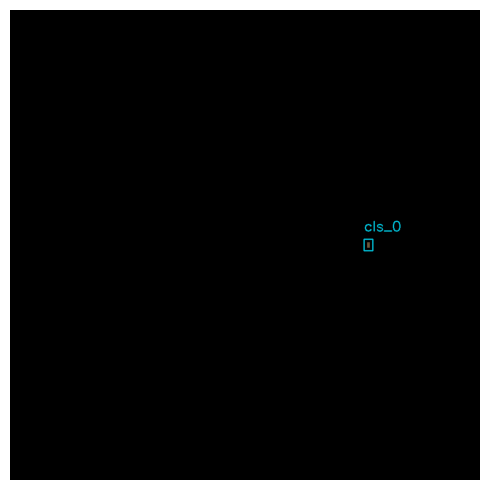

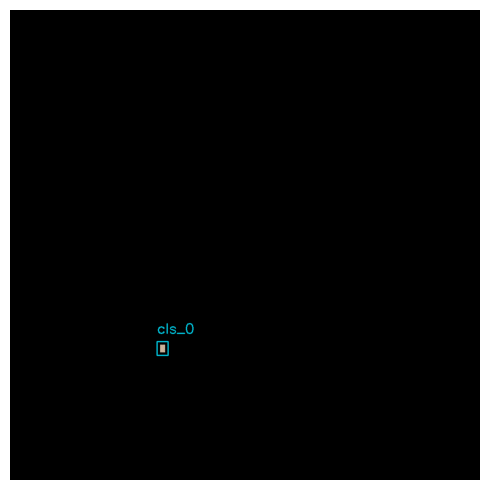

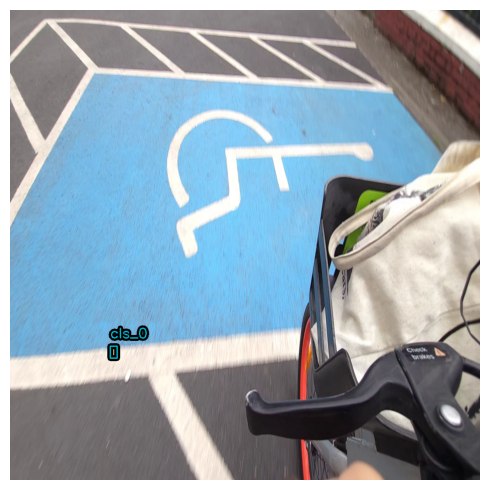

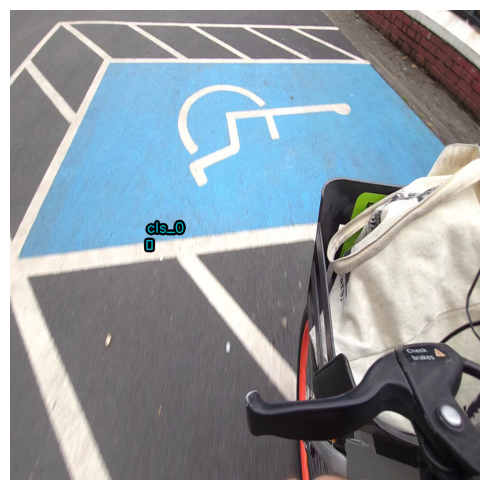

In [6]:
dss = coin_ds('./datasets/synthetic/annotations.xml', d_img=False, d_bb=False)
ds090 = coin_ds('./datasets/090/annotations.xml', 'png', d_img=False, d_bb=False)

visualise_sample(dss.take(2))
visualise_sample(ds090.take(2))

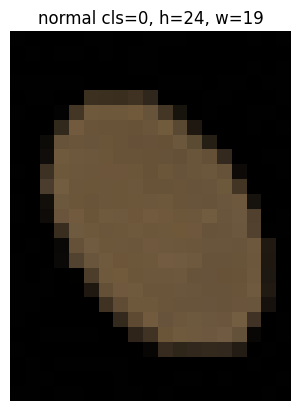

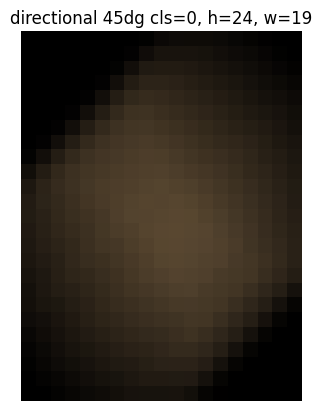

2025-07-31 05:30:11.510905: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


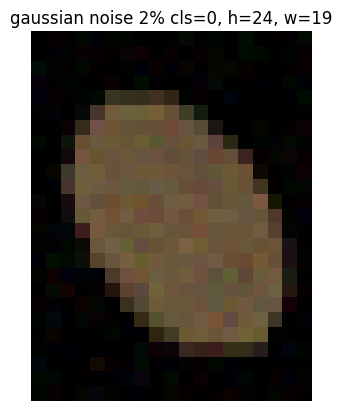

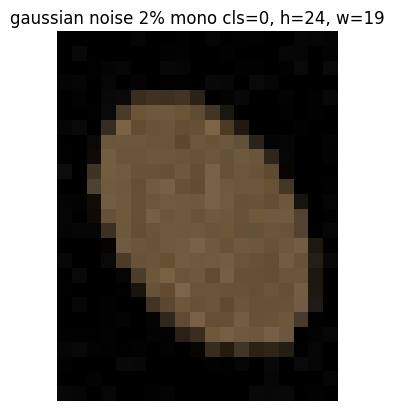

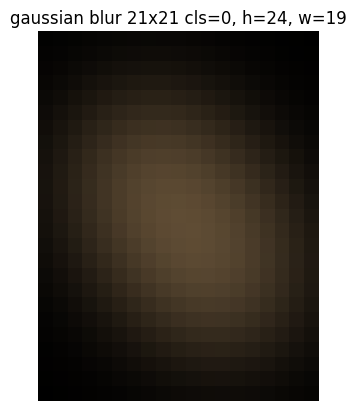

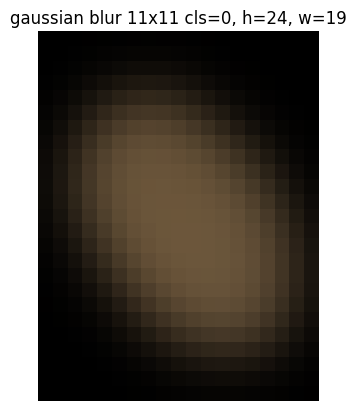

2025-07-31 05:30:12.612807: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


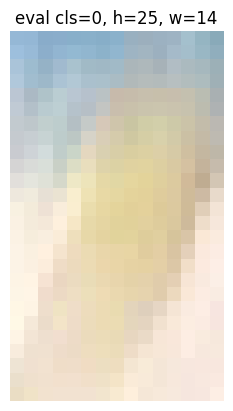

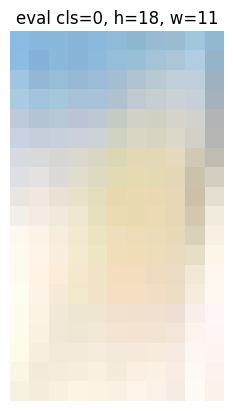

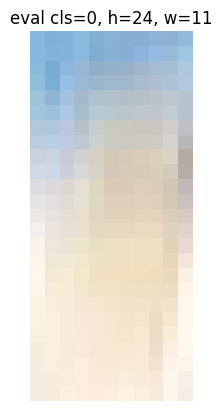

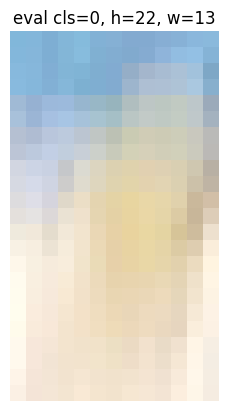

In [7]:
visualise_sample_bboxes(dss.take(1), "normal")
visualise_sample_bboxes(dss.map(apply_directional_blur(45, 15)).take(1), "directional 45dg")
visualise_sample_bboxes(dss.map(apply_gaussian_noise(stddev=0.02)).take(1), "gaussian noise 2%")
visualise_sample_bboxes(dss.map(apply_gaussian_noise(stddev=0.02, monochromatic=True)).take(1),
                        "gaussian noise 2% mono")
visualise_sample_bboxes(dss.map(apply_gaussian_blur(21)).take(1), "gaussian blur 21x21")
visualise_sample_bboxes(dss.map(apply_gaussian_blur(11)).take(1), "gaussian blur 11x11")
visualise_sample_bboxes(ds090.take(4), "eval")

## analyse
get key values for optimal performance later on

In [19]:

def metrics(ds, denominator=5):
    data = []

    for image, boxes, classes in get_real_samples(ds):
        height, width = image.shape[:2]

        for box, clazz in zip(boxes, classes):
            xtl, ytl, xbr, ybr = box

            bw = int((xbr - xtl) * width)
            bh = int((ybr - ytl) * height)

            data.append({
                'bbox_width': bw,
                'bbox_height': bh,
                'aspect_ratio': bw / bh
            })

    df = pd.DataFrame(data)
    print(df.describe())

    ar = df['aspect_ratio'].apply(lambda x: Fraction(x).limit_denominator(denominator))
    mean_frac = Fraction(df['aspect_ratio'].mean()).limit_denominator(10)

    print(
        "Mean aspect ratio:"
        f"{mean_frac.numerator}:{mean_frac.denominator}"
    )

    return ar


print('190:')
ar1 = metrics(coin_ds('./datasets/090/annotations.xml', 'png', d_img=False, d_bb=False))
print('090:')
ar2 = metrics(coin_ds('./datasets/190/annotations.xml', 'png', d_img=False, d_bb=False))
print('synthetic:')
ar3 = metrics(coin_ds('./datasets/synthetic/annotations.xml', d_img=False, d_bb=False))

print("Top 5 aspect ratio 190 and 090:")
for frac, count in Counter(pd.concat([ar1, ar2], ignore_index=True)).most_common(5):
    print(f"{frac.numerator}:{frac.denominator} - {count} times")

190:
          bbox_width    bbox_height  aspect_ratio
count      21.000000      21.000000     21.000000
mean  -257088.333333 -590231.761905      0.520661
std     68031.648024  198613.413155      0.275144
min   -339918.000000 -997603.000000      0.122573
25%   -318231.000000 -724468.000000      0.287129
50%   -273317.000000 -548113.000000      0.498651
75%   -208016.000000 -423158.000000      0.752038
max   -122279.000000 -343398.000000      0.968828
Mean aspect ratio:1:2
090:
          bbox_width    bbox_height  aspect_ratio
count      31.000000      31.000000     31.000000
mean  -419736.516129 -404981.645161      1.780258
std     79299.085142  258052.417333      1.433487
min   -513196.000000 -982787.000000      0.250930
25%   -489160.500000 -578983.000000      0.635439
50%   -434547.000000 -341175.000000      1.273678
75%   -367312.500000 -190219.000000      2.568816
max   -246611.000000  -95925.000000      5.349971
Mean aspect ratio:16:9
synthetic:
          bbox_width   bbox_height

# training model

## gist

In [1]:
backbone = keras_cv.model.EfficientNetV2Backbone.from_preset("efficientnetv2_b0_imagenet", include_rescaling=True)
model = keras_cv.models.RetinaNet(
    num_classes=1,
    bounding_box_format="xywh",
    backbone=backbone,
)

NameError: name 'keras_cv' is not defined

In [ ]:
detector = keras_cv.models.YOLOV8Detector.from_preset("yolo_v8_detector_coco")

In [ ]:
import keras_cv
import keras

image = np.array(keras.utils.load_img("test.jpeg"))
image_resized = keras.ops.image.resize(image, (640, 640))[None, ...]

model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
)
predictions = model.predict(image_resized)

In [35]:

for grid in grid_search({
    'input_size': [(512, 2)],  # h and w, batch size  # 256, 384, 512, 640, 1024
}):
    side, batch_sz = grid['input_size']
    tsz = (side, side)

    with tf.device('/GPU:0'):
        dss = coin_ds('./datasets/synthetic/annotations.xml', d_img=False, d_bb=False)

        ds090 = coin_ds(
            './datasets/090/annotations.xml', 'png', d_img=False, d_bb=False
        ).batch(batch_sz).prefetch(tf.data.AUTOTUNE)

        train_ds = composite_ds(
            dss,
            dss.map(apply_directional_blur(45, 15)),
            # dss.map(apply_gaussian_noise(stddev=0.02)),
            # dss.map(apply_gaussian_noise(stddev=0.02, monochromatic=True)),
            # dss.map(apply_gaussian_blur(21)),
            # dss.map(apply_gaussian_blur(11))
        ).batch(batch_sz).prefetch(tf.data.AUTOTUNE)

        # model = keras_cv.models.RetinaNet(
        #     num_classes=1,
        #     bounding_box_format="xywh",
        #     backbone=keras_cv.models.MobileNetV3Backbone.from_preset('mobilenet_v3_small'),
        #     trainable_backbone=False
        # )

        keras_cv.models.yolov8()
        model.compile(
            optimizer="adam",
            classification_loss="focal",
            box_loss="smoothl1"
        )

        model.summary()

        history = model.fit(
            train_ds,
            validation_data=ds090,
            epochs=100,
            verbose=2,
        )



2025-08-01 03:58:22.288819: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25MiB (rounded to 2359296)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-08-01 03:58:22.290031: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-08-01 03:58:22.290159: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 628, Chunks in use: 628. 157.0KiB allocated for chunks. 157.0KiB in use in bin. 75.3KiB client-requested in use in bin.
2025-08-01 03:58:22.290171: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 391, Chunks in use: 391. 203.2KiB allocated for chunks. 203.2KiB in use in bin. 185.1KiB client-requested in use in bin.
2

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 